In [1]:
# Basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import to_categorical


# Graphing Style
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Cleaning and Exploratory  Data Analysis

In [5]:
face = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/face.csv")

In [6]:
face.shape

(28709, 2)

In [7]:
face["pixels"] = face.pixels.apply(lambda x: np.array(tuple(map(int, x.split()))))

In [8]:
face.head()

,emotion,pixels
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [9]:
face.emotion.value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

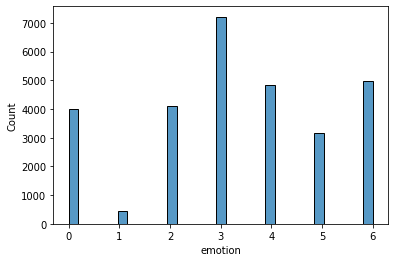

In [10]:
sns.histplot(face.emotion)

In [11]:
emo_di = {0: "Angry", 1:"Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

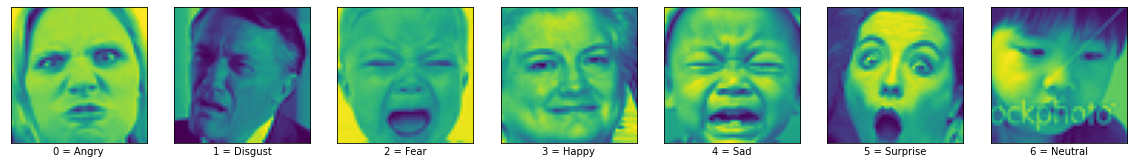

In [12]:
plt.figure(figsize = (20,20))
start_index = 0
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(face[face.emotion == i].pixels.iloc[20].reshape(48,48))
    plt.xlabel("{} = {}".format(i, emo_di[i]))

For each one, consider using Cross Validation and/or PCA

In [13]:
train_x, test_x, train_y, test_y = train_test_split(np.concatenate(np.asarray(face["pixels"])).reshape(-1, 48 * 48), 
                                                    face.emotion, 
                                                    train_size=0.7, 
                                                    random_state=1)
val_x, test_x, val_y, test_y = train_test_split(test_x, test_y, test_size=0.5, random_state=1)


x_mean = np.mean(train_x)
x_std = np.std(train_x) + 1e-10
train_x = (train_x - x_mean) / x_std
val_x = (val_x - x_mean) / x_std
test_x = (test_x - x_mean) / x_std

# Modeling

## Naive Bayes

In [14]:
nb = GaussianNB()
nb.fit(train_x, train_y)

GaussianNB()

In [15]:
nb.score(train_x, train_y)

0.2174562101910828

In [16]:
nb.score(test_x, test_y)

0.2173206408172742

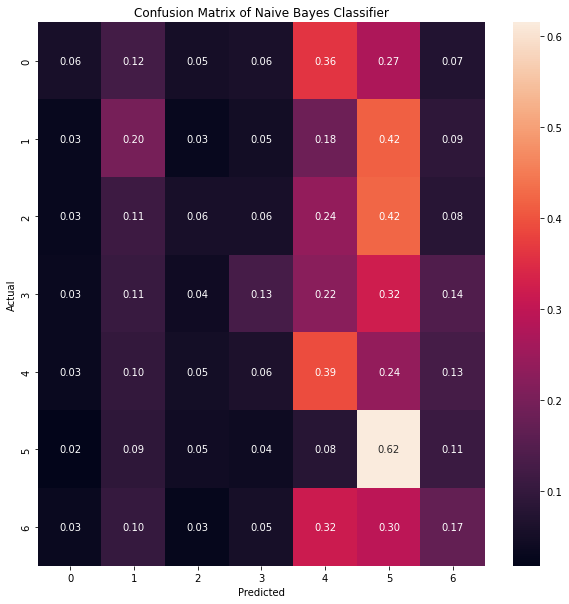

In [19]:
cm = confusion_matrix(test_y, nb.predict(test_x))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of Naive Bayes Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## K-Means + Logistic Regression

In [20]:
pl = Pipeline([
    ("kmeans", KMeans(n_clusters=35)),
    ("logisreg", LogisticRegression(max_iter=10000))
])

In [21]:
pl.fit(train_x, train_y)

Pipeline(steps=[('kmeans', KMeans(n_clusters=35)),
                ('logisreg', LogisticRegression(max_iter=10000))])

In [22]:
pl.score(train_x, train_y)

0.2910031847133758

In [23]:
pl.score(test_x, test_y)

0.3018342233573253

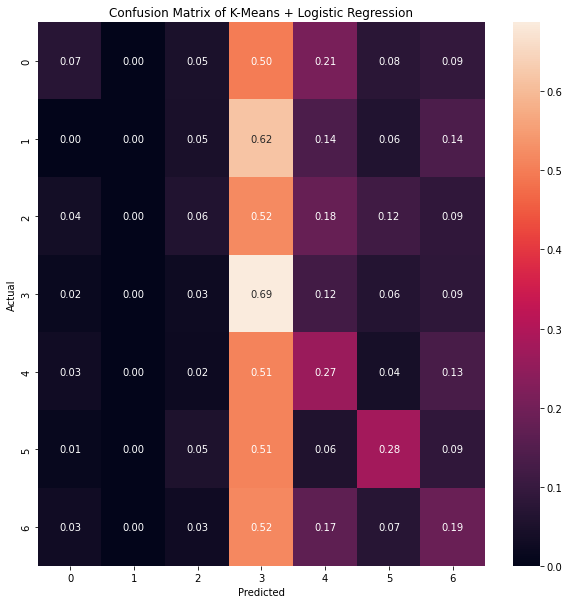

In [24]:
cm = confusion_matrix(test_y, pl.predict(test_x))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of K-Means + Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## KNN with PCA + CV

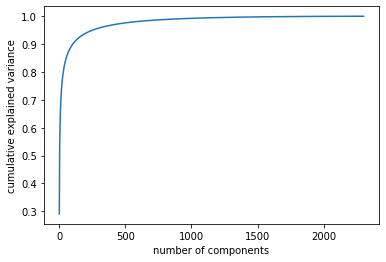

In [25]:
pca = PCA().fit(train_x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [26]:
pl = Pipeline([
    ("PCA", PCA(n_components=100)),
    ("knn", KNeighborsClassifier())
])
params = {"knn__n_neighbors": [1, 3, 5, 7, 12, 15, 20]}
grids = GridSearchCV(pl, params, cv=5)
grids.fit(train_x, train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('PCA', PCA(n_components=100)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 3, 5, 7, 12, 15, 20]})

In [27]:
grids.best_params_

{'knn__n_neighbors': 1}

In [28]:
grids.best_score_

0.3485272195875561

In [29]:
grids.best_estimator_.score(test_x, test_y)

0.3805433016020432

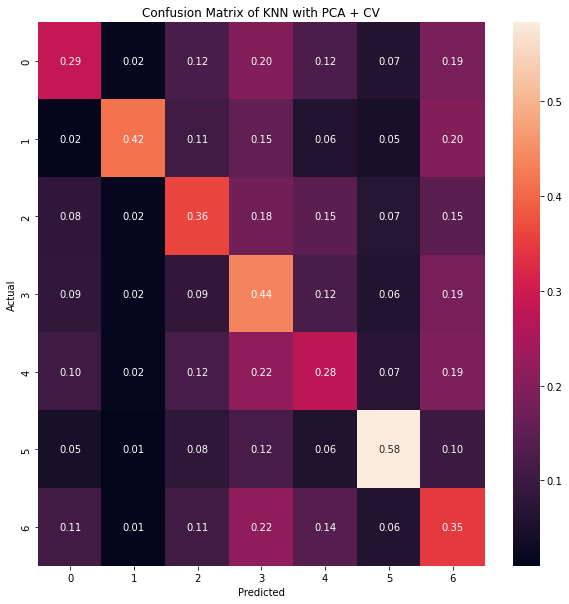

In [30]:
cm = confusion_matrix(test_y, grids.best_estimator_.predict(test_x))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of KNN with PCA + CV')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Random Forest

In [31]:
rfc = RandomForestClassifier(max_depth=5)
rfc.fit(train_x, train_y)

RandomForestClassifier(max_depth=5)

In [32]:
rfc.score(train_x, train_y)

0.3391222133757962

In [33]:
rfc.score(test_x, test_y)

0.3262131413977246

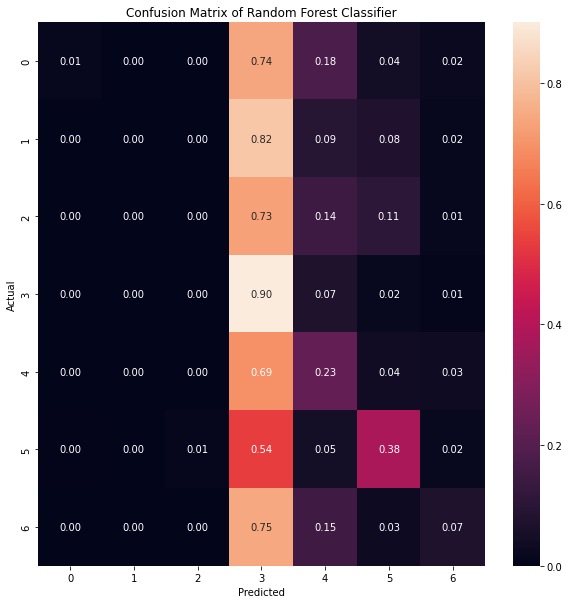

In [35]:
cm = confusion_matrix(test_y, rfc.predict(test_x))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of Random Forest Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Support Vector Machine with PCA

In [36]:
pl = Pipeline([
               ("PCA", PCA(n_components=50)),
               ("svm", SVC())
])
pl.fit(train_x, train_y)

Pipeline(steps=[('PCA', PCA(n_components=50)), ('svm', SVC())])

In [37]:
pl.score(train_x, train_y)

0.528015525477707

In [38]:
pl.score(test_x, test_y)

0.4211748316693754

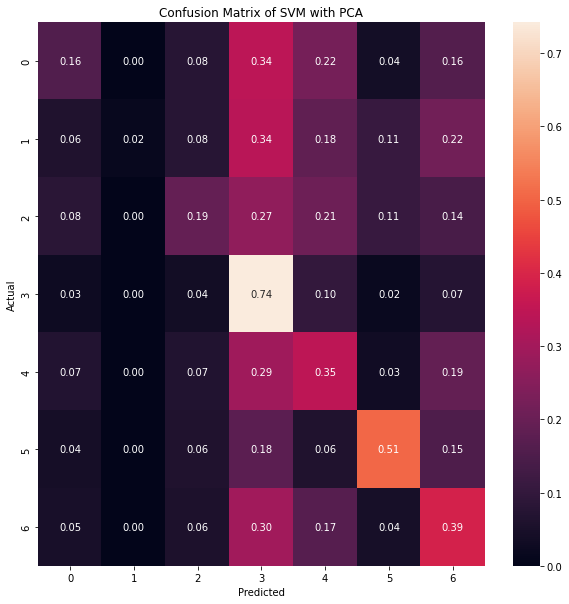

In [39]:
cm = confusion_matrix(test_y, pl.predict(test_x))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of SVM with PCA')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Artificial Neural Network

In [40]:
train_y_cat = to_categorical(train_y)
val_y_cat = to_categorical(val_y)
test_y_cat = to_categorical(test_y)

In [41]:
model = Sequential()
model.add(Dense(256, activation = 'relu', input_shape = (48 * 48,)))
model.add(layers.Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(7, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               590080    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 657,671
Trainable params: 657,671
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(train_x, train_y_cat, epochs = 20, validation_data = (val_x, val_y_cat))

Epoch 1/20
628/628 [==============================] - 3s 3ms/step - loss: 1.9157 - accuracy: 0.2620 - val_loss: 1.7005 - val_accuracy: 0.3281
Epoch 2/20
628/628 [==============================] - 2s 3ms/step - loss: 1.7268 - accuracy: 0.3102 - val_loss: 1.6687 - val_accuracy: 0.3416
Epoch 3/20
628/628 [==============================] - 2s 3ms/step - loss: 1.6865 - accuracy: 0.3293 - val_loss: 1.6284 - val_accuracy: 0.3595
Epoch 4/20
628/628 [==============================] - 2s 3ms/step - loss: 1.6627 - accuracy: 0.3350 - val_loss: 1.6245 - val_accuracy: 0.3500
Epoch 5/20
628/628 [==============================] - 2s 3ms/step - loss: 1.6454 - accuracy: 0.3452 - val_loss: 1.5907 - val_accuracy: 0.3739
Epoch 6/20
628/628 [==============================] - 2s 3ms/step - loss: 1.6265 - accuracy: 0.3529 - val_loss: 1.5924 - val_accuracy: 0.3688
Epoch 7/20
628/628 [==============================] - 2s 3ms/step - loss: 1.6011 - accuracy: 0.3652 - val_loss: 1.5835 - val_accuracy: 0.3716
Epoch 

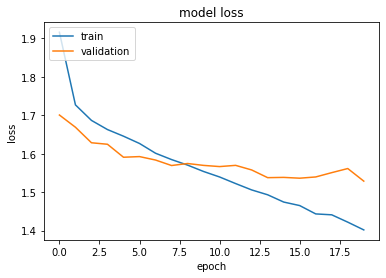

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

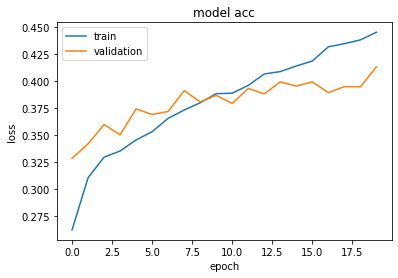

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [43]:
model.evaluate(test_x, test_y_cat)

135/135 [==============================] - 0s 2ms/step - loss: 1.5302 - accuracy: 0.4065


[1.5301593542099, 0.406547486782074]

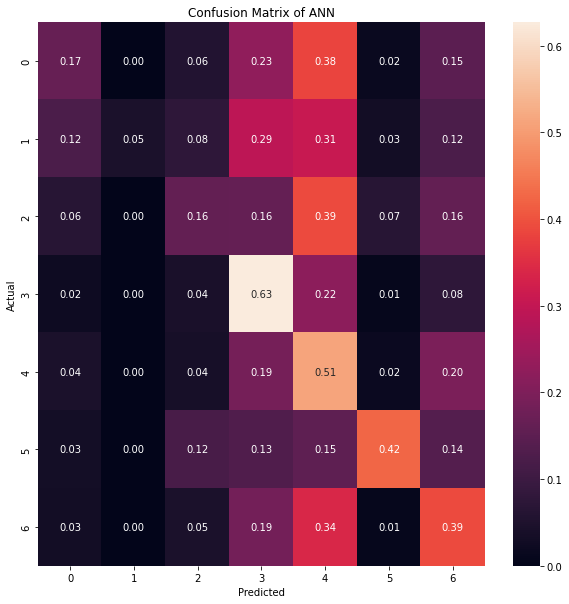

In [50]:
cm = confusion_matrix(test_y, np.apply_along_axis(np.argmax, 1, model.predict(test_x)))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of ANN')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Convolutional Neural Network

In [51]:
train_x_cnn = train_x.reshape(-1, 48, 48, 1)
val_x_cnn = val_x.reshape(-1, 48, 48, 1)
test_x_cnn = test_x.reshape(-1, 48, 48, 1)

In [52]:
model2 = Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(7))

In [53]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 dropout_2 (Dropout)         (None, 21, 21, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 10, 10, 64)       

In [54]:
history2 = model2.fit(train_x_cnn, train_y, epochs = 20, validation_data = (val_x_cnn, val_y))

Epoch 1/20
628/628 [==============================] - 12s 18ms/step - loss: 1.7455 - accuracy: 0.2952 - val_loss: 1.6535 - val_accuracy: 0.3994
Epoch 2/20
628/628 [==============================] - 10s 16ms/step - loss: 1.6020 - accuracy: 0.3716 - val_loss: 1.5413 - val_accuracy: 0.4371
Epoch 3/20
628/628 [==============================] - 10s 17ms/step - loss: 1.5322 - accuracy: 0.4031 - val_loss: 1.4873 - val_accuracy: 0.4603
Epoch 4/20
628/628 [==============================] - 11s 17ms/step - loss: 1.4787 - accuracy: 0.4273 - val_loss: 1.4146 - val_accuracy: 0.4807
Epoch 5/20
628/628 [==============================] - 10s 16ms/step - loss: 1.4423 - accuracy: 0.4407 - val_loss: 1.3823 - val_accuracy: 0.4868
Epoch 6/20
628/628 [==============================] - 10s 16ms/step - loss: 1.4111 - accuracy: 0.4538 - val_loss: 1.3680 - val_accuracy: 0.4998
Epoch 7/20
628/628 [==============================] - 10s 16ms/step - loss: 1.3862 - accuracy: 0.4660 - val_loss: 1.3246 - val_accuracy:

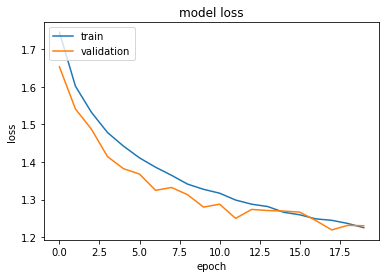

In [55]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

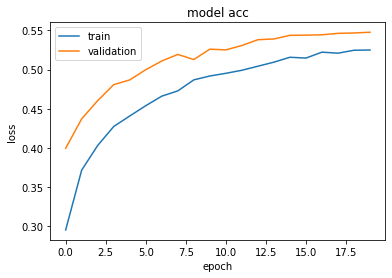

In [56]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [57]:
model2.evaluate(test_x_cnn, test_y)

135/135 [==============================] - 1s 5ms/step - loss: 1.2294 - accuracy: 0.5482


[1.229351282119751, 0.5481773614883423]

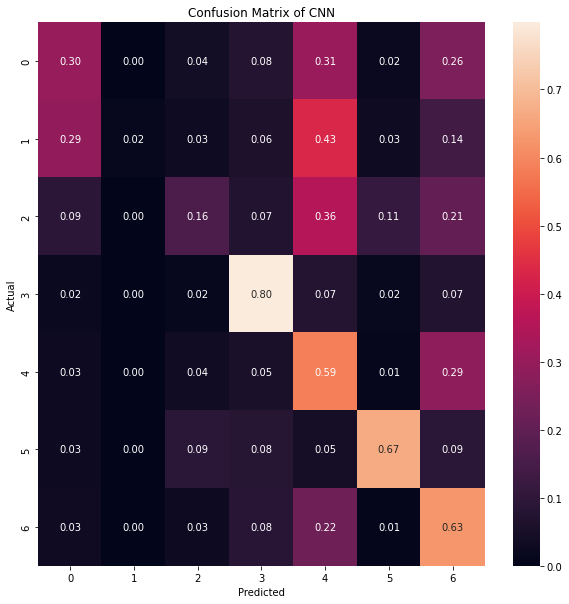

In [81]:
cm = confusion_matrix(test_y, np.apply_along_axis(np.argmax, 1, model2.predict(test_x_cnn)))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix of CNN')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [83]:
model.save('saved_model/ann')
model2.save('saved_model/cnn')

INFO:tensorflow:Assets written to: saved_model/ann/assets
INFO:tensorflow:Assets written to: saved_model/cnn/assets
